# Question 3

In this notebook I'm going to extract all venues from every neighborhood from Toronto, cluster the data and finally plot a map with the result of clustering

### import/install library

In [73]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy  # install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!pip install BeautifulSoup4  # install library
from bs4 import BeautifulSoup  # library to parse html

from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# !pip install folium  # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### load data form previous question

In [5]:
df = pd.read_csv('df2_toronto.csv')  # from previous question

In [6]:
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### load venues from the first neighborhood for testing

In [7]:
LIMIT = 100
radius = 500

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
VERSION = '20180604'
neighborhood_latitude = df.loc[0, 'Latitude']
neighborhood_longitude = df.loc[0, 'Longitude']
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [10]:
print(url)

https://api.foursquare.com/v2/venues/explore?&client_id=ZWT2XVWIG0LTQK0U2TAKGD2CVWHSG4DB5A1PN2UPR0UYQSJC&client_secret=WYLPYX53EWUH3LM1OOVI1JY4D2GKDF0SCOB533UDQ0QIQZQK&v=20180604&ll=43.7532586,-79.3296565&radius=500&limit=100


In [12]:
results = requests.get(url).json()
results
venues = results['response']['groups'][0]['items']

In [13]:
venues

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
   'name': 'Brookbanks Park',
   'location': {'address': 'Toronto',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.751976046055574,
      'lng': -79.33214044722958}],
    'distance': 245,
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
   'categories': [{'id': '4bf58dd8d48988d163941735',
     'name': 'Park',
     'pluralName': 'Parks',
     'shortName': 'Park',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-4e8d9dcdd5fbbbb6b3003c7b-0'},
 {'reasons': {'count': 0,
   'items': [{'

### extract latitud and longitud from venues of testing

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114
2,Corrosion Service Company Limited,Construction & Landscaping,43.752432,-79.334661


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


### extract the venues from all neighborhoods and build a dataframe

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [20]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16


### apply dummyfication to the categorical variable

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(set(toronto_onehot.columns).difference(['Neighborhood']))
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Gift Shop,Dog Run,Art Museum,Shopping Plaza,BBQ Joint,Hakka Restaurant,Swim School,Gastropub,Housing Development,Video Store,Shopping Mall,Garden,Bus Stop,Cajun / Creole Restaurant,Japanese Restaurant,Bakery,Coworking Space,Basketball Court,Tea Room,Field,Theater,Trail,Smoke Shop,Movie Theater,Convenience Store,Gluten-free Restaurant,New American Restaurant,Monument / Landmark,Aquarium,Poke Place,Hotel Bar,Arts & Crafts Store,Gay Bar,Tanning Salon,Beer Store,Bridal Shop,Jazz Club,Taiwanese Restaurant,Eastern European Restaurant,Mobile Phone Shop,Latin American Restaurant,Pub,Convention Center,Frozen Yogurt Shop,Asian Restaurant,Wine Shop,Auto Workshop,College Arts Building,Performing Arts Venue,Grocery Store,Food & Drink Shop,Gaming Cafe,Martial Arts Dojo,Restaurant,Pool,Video Game Store,Social Club,French Restaurant,Boutique,Burrito Place,Brewery,Beer Bar,Fish & Chips Shop,Soup Place,Airport Terminal,Department Store,Bed & Breakfast,Donut Shop,Falafel Restaurant,Cable Car,Stationery Store,Caribbean Restaurant,Basketball Stadium,Dessert Shop,American Restaurant,Lake,Market,Art Gallery,College Auditorium,Ethiopian Restaurant,Food Court,Portuguese Restaurant,Fish Market,Modern European Restaurant,Baby Store,Construction & Landscaping,General Entertainment,Flower Shop,Massage Studio,Snack Place,Lounge,Speakeasy,Middle Eastern Restaurant,Airport Gate,Office,Beach,Accessories Store,Concert Hall,Nightclub,Pharmacy,Bar,College Cafeteria,Women's Store,Korean Restaurant,Bike Shop,Metro Station,Discount Store,Locksmith,Men's Store,Stadium,Farmers Market,Museum,Indonesian Restaurant,Soccer Field,Wings Joint,Hospital,Electronics Store,Fried Chicken Joint,Record Shop,Bank,College Rec Center,Building,IT Services,Bus Line,Flea Market,Scenic Lookout,Strip Club,Irish Pub,Cheese Shop,Supermarket,Belgian Restaurant,Seafood Restaurant,Candy Store,Salad Place,Italian Restaurant,Bubble Tea Shop,Cuban Restaurant,Dance Studio,Sandwich Place,Sculpture Garden,Medical Center,Vegetarian / Vegan Restaurant,Tennis Court,Poutine Place,Plaza,Skating Rink,Molecular Gastronomy Restaurant,Sports Bar,Bus Station,Thai Restaurant,Mediterranean Restaurant,Opera House,Toy / Game Store,Park,Breakfast Spot,Athletics & Sports,Gym / Fitness Center,Filipino Restaurant,Cocktail Bar,Airport,Climbing Gym,River,Comfort Food Restaurant,Noodle House,Brazilian Restaurant,Moroccan Restaurant,Intersection,Other Great Outdoors,Gym,Indie Movie Theater,Cupcake Shop,Fabric Shop,Church,Furniture / Home Store,Health & Beauty Service,Music Venue,Bistro,Dim Sum Restaurant,Cosmetics Shop,Deli / Bodega,Gas Station,Roof Deck,Colombian Restaurant,Clothing Store,Food Truck,Jewelry Store,Kids Store,Doner Restaurant,Luggage Store,Fast Food Restaurant,German Restaurant,Burger Joint,General Travel,Theme Restaurant,Organic Grocery,Spa,Miscellaneous Shop,Rental Car Location,Pizza Place,Hardware Store,Motel,Sake Bar,Food,Harbor / Marina,Skate Park,Supplement Shop,Train Station,Shoe Store,Fruit & Vegetable Store,Plane,Golf Course,Distribution Center,Garden Center,Baseball Stadium,Airport Service,Ice Cream Shop,Hockey Arena,Optical Shop,Diner,Curling Ice,Ramen Restaurant,Mexican Restaurant,Coffee Shop,College Gym,Tailor Shop,Hobby Shop,Bookstore,Airport Lounge,Sushi Restaurant,Liquor Store,Hotel,Gourmet Shop,Sporting Goods Shop,Historic Site,Drugstore,Baseball Field,Wine Bar,Playground,Lingerie Store,Chocolate Shop,Yoga Studio,Steakhouse,Airport Food Court,Juice Bar,Comic Shop,Health Food Store,Fountain,Pet Store,Café,Salon / Barbershop,College Stadium,Chinese Restaurant,Vietnamese Restaurant,History Museum,Boat or Ferry,Warehouse Store,Greek Restaurant,Antique Shop,Home Service,Butcher,Hookah Bar,Business Service,Light Rail Station,Creperie,Indian Restaurant,Post Office,Event Space,Bagel Shop
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### group with mean

In [32]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Gift Shop,Dog Run,Art Museum,Shopping Plaza,BBQ Joint,Hakka Restaurant,Swim School,Gastropub,Housing Development,Video Store,Shopping Mall,Garden,Bus Stop,Cajun / Creole Restaurant,Japanese Restaurant,Bakery,Coworking Space,Basketball Court,Tea Room,Field,Theater,Trail,Smoke Shop,Movie Theater,Convenience Store,Gluten-free Restaurant,New American Restaurant,Monument / Landmark,Aquarium,Poke Place,Hotel Bar,Arts & Crafts Store,Gay Bar,Tanning Salon,Beer Store,Bridal Shop,Jazz Club,Taiwanese Restaurant,Eastern European Restaurant,Mobile Phone Shop,Latin American Restaurant,Pub,Convention Center,Frozen Yogurt Shop,Asian Restaurant,Wine Shop,Auto Workshop,College Arts Building,Performing Arts Venue,Grocery Store,Food & Drink Shop,Gaming Cafe,Martial Arts Dojo,Restaurant,Pool,Video Game Store,Social Club,French Restaurant,Boutique,Burrito Place,Brewery,Beer Bar,Fish & Chips Shop,Soup Place,Airport Terminal,Department Store,Bed & Breakfast,Donut Shop,Falafel Restaurant,Cable Car,Stationery Store,Caribbean Restaurant,Basketball Stadium,Dessert Shop,American Restaurant,Lake,Market,Art Gallery,College Auditorium,Ethiopian Restaurant,Food Court,Portuguese Restaurant,Fish Market,Modern European Restaurant,Baby Store,Construction & Landscaping,General Entertainment,Flower Shop,Massage Studio,Snack Place,Lounge,Speakeasy,Middle Eastern Restaurant,Airport Gate,Office,Beach,Accessories Store,Concert Hall,Nightclub,Pharmacy,Bar,College Cafeteria,Women's Store,Korean Restaurant,Bike Shop,Metro Station,Discount Store,Locksmith,Men's Store,Stadium,Farmers Market,Museum,Indonesian Restaurant,Soccer Field,Wings Joint,Hospital,Electronics Store,Fried Chicken Joint,Record Shop,Bank,College Rec Center,Building,IT Services,Bus Line,Flea Market,Scenic Lookout,Strip Club,Irish Pub,Cheese Shop,Supermarket,Belgian Restaurant,Seafood Restaurant,Candy Store,Salad Place,Italian Restaurant,Bubble Tea Shop,Cuban Restaurant,Dance Studio,Sandwich Place,Sculpture Garden,Medical Center,Vegetarian / Vegan Restaurant,Tennis Court,Poutine Place,Plaza,Skating Rink,Molecular Gastronomy Restaurant,Sports Bar,Bus Station,Thai Restaurant,Mediterranean Restaurant,Opera House,Toy / Game Store,Park,Breakfast Spot,Athletics & Sports,Gym / Fitness Center,Filipino Restaurant,Cocktail Bar,Airport,Climbing Gym,River,Comfort Food Restaurant,Noodle House,Brazilian Restaurant,Moroccan Restaurant,Intersection,Other Great Outdoors,Gym,Indie Movie Theater,Cupcake Shop,Fabric Shop,Church,Furniture / Home Store,Health & Beauty Service,Music Venue,Bistro,Dim Sum Restaurant,Cosmetics Shop,Deli / Bodega,Gas Station,Roof Deck,Colombian Restaurant,Clothing Store,Food Truck,Jewelry Store,Kids Store,Doner Restaurant,Luggage Store,Fast Food Restaurant,German Restaurant,Burger Joint,General Travel,Theme Restaurant,Organic Grocery,Spa,Miscellaneous Shop,Rental Car Location,Pizza Place,Hardware Store,Motel,Sake Bar,Food,Harbor / Marina,Skate Park,Supplement Shop,Train Station,Shoe Store,Fruit & Vegetable Store,Plane,Golf Course,Distribution Center,Garden Center,Baseball Stadium,Airport Service,Ice Cream Shop,Hockey Arena,Optical Shop,Diner,Curling Ice,Ramen Restaurant,Mexican Restaurant,Coffee Shop,College Gym,Tailor Shop,Hobby Shop,Bookstore,Airport Lounge,Sushi Restaurant,Liquor Store,Hotel,Gourmet Shop,Sporting Goods Shop,Historic Site,Drugstore,Baseball Field,Wine Bar,Playground,Lingerie Store,Chocolate Shop,Yoga Studio,Steakhouse,Airport Food Court,Juice Bar,Comic Shop,Health Food Store,Fountain,Pet Store,Café,Salon / Barbershop,College Stadium,Chinese Restaurant,Vietnamese Restaurant,History Museum,Boat or Ferry,Warehouse Store,Greek Restaurant,Antique Shop,Home Service,Butcher,Hookah Bar,Business Service,Light Rail Station,Creperie,Indian Restaurant,Post Office,Event Space,Bagel Shop
0,Agincourt,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0

### Explore the data

In [69]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot  0.33
1  Latin American Restaurant  0.33
2                     Lounge  0.33
3                  Gift Shop  0.00
4             Cosmetics Shop  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1  Sandwich Place  0.12
2             Gym  0.12
3        Pharmacy  0.12
4     Coffee Shop  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.10
1                Coffee Shop  0.10
2             Sandwich Place  0.05
3          Convenience Store  0.05
4  Middle Eastern Restaurant  0.05


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Bank  0.25
2                 Café  0.25
3  Japanese Restaurant  0.25
4       Cosmetics Shop  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.08

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### the most common category of every neighborhood

In [71]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Bagel Shop,Speakeasy
1,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Sandwich Place,Pub
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Pet Store,Sandwich Place
3,Bayview Village,Café,Chinese Restaurant,Japanese Restaurant,Bank,Fish Market
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Pizza Place,Italian Restaurant,Sandwich Place


### kmeans with k=3

In [67]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
pd.value_counts(kmeans.labels_)

0    82
2    10
1     1
dtype: int64

most neighborhoods fall in the same cluster

In [63]:
toronto_clustered = toronto_grouped.copy(deep=True)
toronto_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_clustered = toronto_clustered[['Neighborhood', 'Cluster Labels']]
toronto_clustered.head()


,Neighborhood,Cluster Labels
0,Agincourt,0
1,"Alderwood, Long Branch",0
2,"Bathurst Manor, Wilson Heights, Downsview North",0
3,Bayview Village,0
4,"Bedford Park, Lawrence Manor East",0


### merge dataframe with coordinates with dataframe with kmeans results

In [64]:
toronto_clustered = toronto_clustered.merge(df, on='Neighborhood')
toronto_clustered.head()

### Finally plot the results

In [92]:
latitude = 43.651070
longitude = -79.347015
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_clustered['Latitude'], toronto_clustered['Longitude'], toronto_clustered['Neighborhood'], toronto_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters



### How github does not render folium maps correctly, plot neighborhood with matplolib

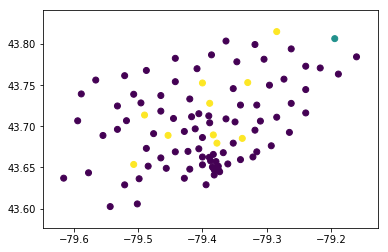

In [101]:
plt.scatter(toronto_clustered['Longitude'], toronto_clustered['Latitude'], c=toronto_clustered['Cluster Labels'])